# ADA Milestone 2
# Project Title: Unveiling ingredient combinations

Team members: Yan Fu, Kristijan Lopatichki, Zhechen Su

# Part 0: Importing Library

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
from os import walk
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [3]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,5)})

# Part 1: Data Collection and Extraction

Generally, in this part we finished these tasks:

* Scraped over 40,000 web pages out of 93,000 html in `Cooking recipes` dataset, and created csv files with useful information ( including title of dishes, nutritions, ingredients, cooking time, cuisine type etc.)

* Cleaned and extracted data from 1.85 GB of `OpenFood.csv` data.

* Downloaded and reconstructed public health .csv files from [WHO](http://apps.who.int/gho/data/node.main.A858?lang=en) official website.

## 1.1 Dataset 1: Cooking recipes

The first dataset is `Cooking recipes`: 2.53 GB of zipped data and concludes more than 93,000 html web pages on recipes. 

1. First we use the first part of the script `move_webpages_to_folders.py` to find out how many unique websites are in `Cooking recipes` and the corresponding counts. The result of every html and their website is saved in `TotalHtml2Page.csv`. 

In [6]:
Html2Pages = pd.read_csv('./Input data/TotalHtml2Page.csv')

In [7]:
Html2Pages.head(3)

,website,htmlfile
0,www.drinksmixer.com,5af7259d1ce7d3095ccc9759c085ae17.html
1,www.drinksmixer.com,32cbba91293a8033b95a25b6301dd6a1.html
2,www.cooks.com,9123840613475868b58996e21d4b5095.html


In [8]:
Html2Pages.website.value_counts()

allrecipes.com                23696
www.food.com                  11843
www.foodnetwork.com           10000
www.cooks.com                  5525
www.yummly.com                 4827
www.epicurious.com             4228
www.tasteofhome.com            3787
www.myrecipes.com              3038
recipes.sparkpeople.com        2864
www.cdkitchen.com              2138
southernfood.about.com         2012
www.bettycrocker.com           1921
www.grouprecipes.com           1916
cookeatshare.com               1573
www.recipe.com                 1175
www.ifood.tv                   1137
www.kraftrecipes.com           1122
www.eatingwell.com             1118
www.taste.com.au                980
www.delish.com                  869
simplyrecipes.com               729
homecooking.about.com           607
www.foodandwine.com             532
nullhtml                        529
busycooks.about.com             461
www.recipetips.com              437
www.familyoven.com              406
www.drinksmixer.com         

From the results above, we can notice that we have 119 different webpages where the first three domains contain almost half of the data. To save time, we decide to do web scraping on websites with large enough counts, namely `allrecipes.com`, `food.com`, `foodnetwork.com`, `cooks.com` and `yummly.com`, whose total counts cover 60% html files of the original `Cooking Recipes` dataset.

However, `cooks.com` HTML files contained only search results but not recipes. And `yummly.com` is written in javascript structure and is too difficult to parse. Instead, we used web scraping on `yummly.com` in real time to obtain more data and parse it easier as will be shown below. Furhermore, we downloaded `yummly` dataset from another [source](http://isia.ict.ac.cn/dataset/Yummly-66K.html), which was crawled from Yummly API.

In the next steps we:

2. Decided to extract data from `allrecipes.com`, `food.com`, `foodnetwork.com` and `yummly.com`. Before that we used the second part of `move_webpages_to_folders.py` to move corresponding html files to their own folders.

3. Used scripts: `allrecipes_parsing.py`, `food_parsing.py`, `foodnetwork_parsing.py` and `yummly_parsing.py` for web scraping.

4. Generally from each web page we infer information which includes the name of the dish, preparation time, ratings, review counts, type of cuisine, the ingredients, directions for preparation and nutritional facts except in the cases where certain web pages do not contain some of the mentioned data. Saved the result as .csv file.

Things to be noticed for web scraping:

1. The html files in `Cooking recipes` include null pages or search result pages. We discarded numerous invalid HTML addresses and redundant data in the datasets and end up with around 27000 recipes in total. As for the last source `yummly.com` we have a subset of around 59607 recipes.

2. Different website used different unit(eg. minute, hour, g, kg). We transformed all the data into same unit while collecting data (eg. time all in minutes and nutritient in g or mg).

In total, we now have **86607** recipes.

In [5]:
# Load data from allrecipes.com
allrecipes = pd.read_csv('Input data/allrecipes_df.csv')
allrecipes.drop(columns='Unnamed: 0', inplace=True)

In [6]:
# Load data from food.com
food = pd.read_csv('Input data/food_df.csv')
food.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
# Load data from foodnetwork.com
foodnetwork = pd.read_csv('Input data/foodnetwork_df.csv')
foodnetwork.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
# Load data from yummly.com
yummly = pd.read_csv('Input data/yummly-all.csv')
yummly.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

In [12]:
# Load data from yummly.com
yummly.head(2)

,Calories,Cholesterol (mg),Dietaryfiber (g),Fat (g),Protein (g),Rating,Ready in (min),Reviews,Sodium (mg),Title,Totalcarbs (g),course,cuisine,flavors,id,ingredients,name
0,140.0,NaN,3.0,11.0,2.0,NaN,25,0,180.0,Broccoli Gazpacho,9.0,['Soups'],Spanish,"{'meaty': 0.16666666666666602, 'sour': 0.83333...",Broccoli-Gazpacho-1927556,"['tomatoes', 'small yellow onion', 'garlic', '...",Broccoli Gazpacho
1,60.0,NaN,1.0,5.0,1.0,4.0,20,1,200.0,Strawberry Melon Gazpacho,4.0,['Soups'],Spanish,"{'meaty': 0.16666666666666602, 'sour': 0.5, 's...",Strawberry-Melon-Gazpacho-1088789,"['melon', 'cucumber', 'extra-virgin olive oil'...",Strawberry Melon Gazpacho


In [13]:
yummly.columns=['Calories', 'Cholesterol_mg', 'Dietaryfiber_g', 'Fat_g',
       'Protein_g', 'Rating', 'Total_Time_min', 'Reviews', 'Sodium_mg',
       'Title', 'Totalcarbs_g', 'course', 'Cuisine', 'flavors', 'id',
       'Ingredients', 'name']

In [14]:
yummly.to_csv('Input data/yummly-all.csv',index=False)

In [16]:
yummly.count()

Calories          53508
Cholesterol_mg    42782
Dietaryfiber_g    52437
Fat_g             53554
Protein_g         53486
Rating             9785
Total_Time_min    59607
Reviews           59607
Sodium_mg         53559
Title             59607
Totalcarbs_g      53357
course            59607
Cuisine           59607
flavors           58093
id                59607
Ingredients       59607
name              59607
dtype: int64

Below we show the information we gathered from the datasets. 
1. In general, all four datasets include name of dish, review counts, ingredients and cooking time.
2. Nutrition information is lacked in foodnetwork dataset.
3. Rating is lacked in food dataset.
4. Type of cuisine is only available in foodnetwork and yummly datasets, with over 20,000 recipes.

We also noticed there is small percentage of missing values in our data. Following msno module we visualized the missing values in our data, where a white line points to a missing value. We found that for certain websites the missing rate of certain feature was high (eg. `food` not having any ratings, `yummly` missing a lot ratings).

In order to analyze on enough data examples we would better split our dataset into different categories, eg. nutritrients, ingredients, cooking time and etc, and give different analysis on different categories.

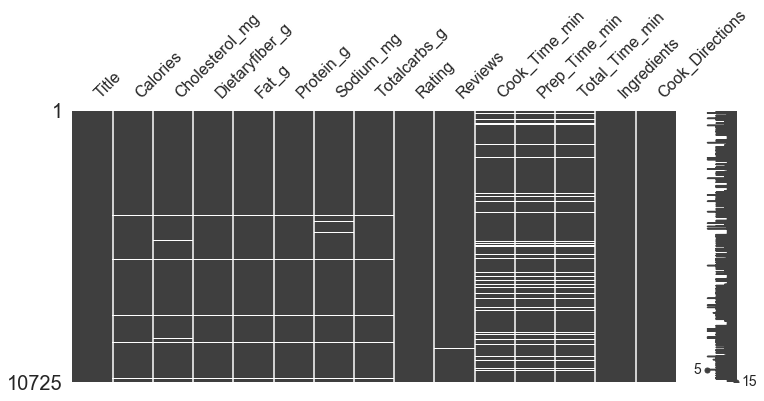

In [270]:
msno.matrix(allrecipes,figsize=(12, 5))#.info()

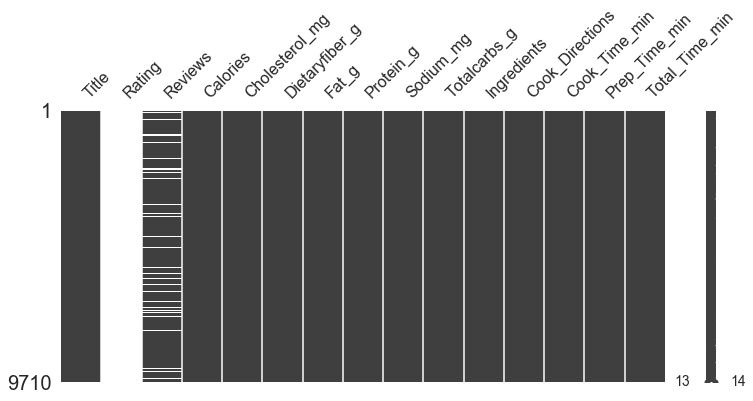

In [271]:
msno.matrix(food,figsize=(12, 5))

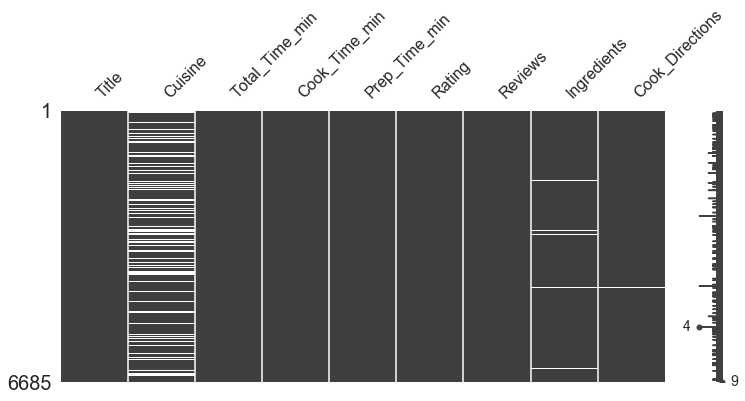

In [272]:
msno.matrix(foodnetwork,figsize=(12, 5))#.info()

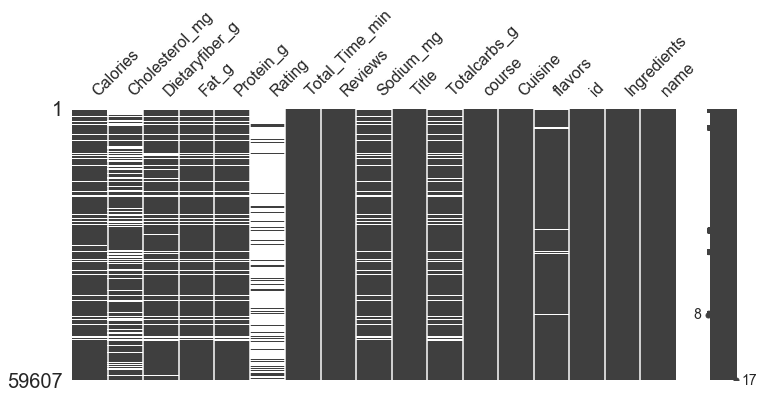

In [15]:
msno.matrix(yummly,figsize=(12, 5))#.info()

## 1.2 Dataset 2: OpenFood
Then we continue with `Open food dataset`: 1.6 GB in csv format, containing food product from all over the world.

From the origin `Open food dataset` we extracted product name, country, origins, ingredients and nutrition informations. 

The total number of food products is **672551**.

Further we will use this dataset to find out where the recipes from `Cooking recipes dataset` come from, thus trying to figure out regional differences in ingredients.

In [42]:
openfood_raw = pd.read_csv('./dataset/openfood.csv',sep='\t')
openfood_select = openfood_raw[['product_name','countries_en','ingredients_text',
                            'energy_100g','fat_100g','cholesterol_100g','carbohydrates_100g',
                            'sugars_100g','fiber_100g','proteins_100g','salt_100g','sodium_100g','nutrition_grade_fr']]
openfood_notnull = openfood_select[pd.notnull(openfood_select['product_name'])].reset_index().drop(columns='index')
openfood_notnull = openfood_notnull[pd.notnull(openfood_notnull['countries_en'])].reset_index().drop(columns='index')
openfood_notnull.to_csv('./Input data/OpenFoodCleaned.csv',index=False)

In [43]:
openfood = pd.read_csv('./Input data/OpenFoodCleaned.csv')

In [44]:
openfood.head(2)

,product_name,countries_en,ingredients_text,energy_100g,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_grade_fr
0,Vitória crackers,France,NaN,1569.0,7.0,NaN,70.1,15.0,NaN,7.8,1.4,0.551181,NaN
1,Cacao,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
openfood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672551 entries, 0 to 672550
Data columns (total 13 columns):
product_name          672551 non-null object
countries_en          672551 non-null object
ingredients_text      392550 non-null object
energy_100g           592770 non-null float64
fat_100g              587457 non-null float64
cholesterol_100g      144495 non-null float64
carbohydrates_100g    587197 non-null float64
sugars_100g           577017 non-null float64
fiber_100g            272255 non-null float64
proteins_100g         591390 non-null float64
salt_100g             571944 non-null float64
sodium_100g           571916 non-null float64
nutrition_grade_fr    140963 non-null object
dtypes: float64(9), object(4)
memory usage: 66.7+ MB


Now we have over 20,000 recipes from `yummly` and `foodnetwork` with cuisines, and we plan to use `OpenFood` to enrich our data for the cuisine type of `food` and `allrecipes`. 

An example of recipes 'Garlic Mashed Potatoes' from `allrecipes` is given below. We matched the recipes names with OpenFood product name, and from the countries we can then know where the recipe should belong to. For example, we found 11 products related to 'Garlic Mashed Potatoes' are sold in the US and one in Mexico, then we can assume that 'Garlic Mashed Potatoes' belongs to American cuisine.

<font color='red'>
    TO BE DONE.
    </font>
Very few proportion of recipes from `food` and `allrecipes` can match with `OpenFood` dataset. The problem may be that the matching constraint is not very well yet. We are still thinking of different ways on how to improve it.

In [450]:
openfood.loc[openfood.product_name.str.lower().str.contains('Garlic Mashed Potatoes'.lower())]

,product_name,countries_en,ingredients_text,energy_100g,fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
5853,"Idaho Spuds, Roasted Garlic Mashed Potatoes",United States,"Idaho potato (dry), palm oil, salt, corn syrup...",1548.0,7.41,0.000,70.37,3.70,7.400,7.41,5.36194,2.111
17529,"Potatoes, Garlic Mashed Potatoes",United States,"Potatoes, whole milk, butter (cream, salt), ma...",406.0,4.84,0.008,12.10,1.61,0.800,2.42,0.90170,0.355
20165,Roasted Garlic Mashed Potatoes,United States,"Idho potatoes with emulsifier,(mono & diglycer...",1703.0,14.81,0.000,62.96,3.70,3.700,7.41,4.04622,1.593
27346,ROASTED GARLIC MASHED POTATOES,Mexico,"PAPAS, ACEITE VEGETAL, ACEITES VEGETALES: ACEI...",333.0,1.78,0.000,14.30,1.43,0.718,1.43,1050.00000,414.000
27407,Roasted Garlic Mashed Potatoes,United States,"Ingredients: idaho potatoes, vegetable oil (co...",1644.0,8.93,0.000,71.43,7.14,3.600,7.14,5.26034,2.071
37979,Garlic Mashed Potatoes,United States,"Potatoes, milk, butter (cream and salt), conta...",356.0,2.82,0.007,13.38,1.41,0.700,1.41,0.91186,0.359
43804,Roasted Garlic Mashed Potatoes,United States,"Ingredients: potatoes, maltodextrin, coconut o...",1548.0,3.70,0.000,74.07,3.70,3.700,7.41,3.29184,1.296
82786,Garlic Mashed Potatoes,United States,"Potatoes, whole milk, butter (sweet cream, sal...",506.0,4.84,0.008,16.94,0.81,1.600,2.42,0.88138,0.347
82813,Roasted Garlic Mashed Potatoes With Parmesan C...,United States,"Potatoes, whole milk, margarne (liquid and hyd...",506.0,4.84,0.004,16.13,0.81,1.600,3.23,1.10490,0.435
111507,Organic Garlic Mashed Potatoes,United States,"Organic potatoes, organic whipping cream (past...",837.0,11.43,0.036,21.43,1.43,2.100,2.86,0.81534,0.321


In [451]:
openfood.loc[openfood.product_name.str.lower().str.contains('Garlic Mashed Potatoes'.lower())]['countries_en'].value_counts()

United States    11
Mexico            1
Name: countries_en, dtype: int64

## 1.3 Dataset 3: WHO public health

Regarding our last question we include dataset [WHO](http://apps.who.int/gho/data/node.main.A858?lang=en) where we can go even further to analyze the possible relationship between regional recipes or favored ingredients and public health.

In this part we are working on the WHO dataset downloaded from WHO website. And the data including ratio of country population on:
1. High blood pressure (blood pressure over SBP140)
2. Cholesterol on two levels (190mg/dl for a little bit high and 240mg/dl for very high cholesterol)
3. BMI (BMI>25 for overweight and BMI>30 for obesity) 
4. death rate of noncommunicable diseases (including heart disease, stroke, cancer, diabetes and chronic lung disease). 

And we choose statistics data in the same year as possible.

The output data is in aggregation of risk factors and sex by **195** countries, intended to estimate regional specific public health condition. And the ratio is calculated after age-standardized (per 100 000 population). Age standardization is used to allow populations to be compared when the age profiles of the populations are quite different.


In [14]:
FILE_FOLDER = './dataset/WHO/'
BP_2015 = pd.read_csv(FILE_FOLDER+'BloodPressureSBP140.csv',skiprows=3).iloc[:,0:4] #blood pressure
NCD = pd.read_csv(FILE_FOLDER+'NoncommunicableDiseasesByCountry.csv',skiprows=2).iloc[:,0:5] # noncommunicable disease
NCD_2015 = NCD.loc[NCD.Year==2015].copy().reset_index().drop(columns=['Year','index'])

In [15]:
idx = [0,3,4,5]
Chol_2008_190 = pd.read_csv(FILE_FOLDER+'Cholesterol190ByCountry.csv',skiprows=1).iloc[:,idx]
Chol_2008_240 = pd.read_csv(FILE_FOLDER+'Cholesterol240ByCountry.csv',skiprows=1).iloc[:,idx]
Chol = pd.merge(Chol_2008_240,Chol_2008_190,how='outer',on='Country',suffixes=('_chol240','_chol190'))#cholesterol
idx = [0,4,5,6]

In [16]:
BMI_2015_25 = pd.read_csv(FILE_FOLDER+'NCD_BMI_25A.csv',skiprows=3).iloc[:,idx]
BMI_2015_25.columns=['Country','Both sexes','Male','Female']
BMI_2015_30 = pd.read_csv(FILE_FOLDER+'NCD_BMI_30A.csv',skiprows=3).iloc[:,idx]
BMI_2015_30.columns=['Country','Both sexes','Male','Female']
BMI = pd.merge(BMI_2015_25,BMI_2015_30,how='outer',on='Country',suffixes=('_BMI25','_BMI30'))#BMI

In [17]:
tmp1 = pd.merge(Chol,BMI,how='outer',on='Country',suffixes=('',''))
tmp2 = pd.merge(NCD_2015,BP_2015,how='outer',on='Country',suffixes=('_NCD','_BP'))
WHOdata = pd.merge(tmp1,tmp2,how='outer',on='Country',suffixes=('',''))
WHOdata.to_csv('./SavedList/WHOdata.csv')
WHOdata.head(2)

,Country,Both sexes_chol240,Male_chol240,Female_chol240,Both sexes_chol190,Male_chol190,Female_chol190,Both sexes_BMI25,Male_BMI25,Female_BMI25,Both sexes_BMI30,Male_BMI30,Female_BMI30,Both sexes_NCD,Male_NCD,Female_NCD,Both sexes_BP,Male_BP,Female_BP
0,Afghanistan,4.0 [1.7-8.1],3.5 [1.0-8.3],4.5 [1.2-11.6],21.9 [11.0-36.5],20.9 [7.5-40.1],22.8 [7.6-46.1],22.3 [18.1-27.0],19.1 [13.2-26.2],25.4 [19.7-32.0],5.2 [3.3-7.7],3.0 [1.3-6.0],7.3 [4.1-11.8],848.6,902.3,801.4,30.6 [23.6-38.3],30.4 [20.4-41.6],30.7 [21.2-41.3]
1,Albania,12.0 [5.9-21.1],11.3 [4.2-23.5],12.6 [4.0-27.4],45.3 [29.8-61.0],46.3 [25.2-68.0],44.3 [21.6-67.2],57.0 [52.2-61.6],63.6 [56.8-69.9],50.5 [43.9-57.2],21.1 [16.6-26.0],20.9 [14.4-28.1],21.3 [15.1-28.1],569.5,664.8,483.6,29.0 [22.4-36.2],33.0 [23.0-44.3],25.0 [16.8-34.7]




# Part 2: Data process and analysis

## 2.1 Ingredients & Cuisines

For the second question we can identify the key ingredients for different recipes by counting frequency. The main ideas are:

1. Dropping words which are not ingredients in the 'Ingredients' column.
2. Counting the frequency of ingredients and getting the most popular ingredients for different cuisines.
3. Finding ingredient pairs (eg. ingredients always come up together)
<font color='red'>
(TO BE DONE)
    </font>

In [306]:
cuisine = pd.concat([foodnetwork.iloc[:,[0,1]].copy(),yummly.iloc[:,[9,13]].copy()],sort=False)
cuisine.dropna(how='any',inplace=True)
cuisine.set_index('Title', inplace=True)

In [308]:
cuisine.Cuisine.value_counts()

French           5741
Chinese          4751
Mexican          4703
American         2955
European         1059
Asian             283
Latin             191
Middle             86
Caribbean          70
Italian            54
Jewish             28
African            24
Mediterranean      14
British            10
Californian         8
South               7
Eastern             7
Japanese            4
Indian              3
with                3
Canadian            2
Greek               2
Irish               2
Scandinavian        2
Spanish             2
Thai                1
Hawaiian            1
Portuguese          1
German              1
Name: Cuisine, dtype: int64

We can see our current dataset focused mostly on French, Chinese, Mexican and American food. 

In [274]:
ingredients_raw = pd.concat([allrecipes.iloc[:,[0,13]].copy(),food.iloc[:,[0,10]].copy(),
                     foodnetwork.iloc[:,[0,7]].copy(),yummly.iloc[:,[9,15]].copy()],sort=False)
ingredients_raw.drop_duplicates('Title', inplace=True)
ingredients_raw.set_index('Title', inplace=True)
ingredients_raw.dropna(how='all', inplace=True)

In [275]:
words=[]
for i in range(len(ingredients_raw.Ingredients)):
    words += list(filter(None, re.findall("[A-Za-z]*", str(ingredients_raw.Ingredients[i]))))
words_df = pd.DataFrame(words, columns=['Words'])
words_df.Words.value_counts().head(10)

cup            57683
teaspoon       36113
tablespoons    24293
cups           22816
salt           22675
chopped        21966
pepper         21641
oil            18227
sugar          17880
ground         16553
Name: Words, dtype: int64

In [277]:
words_df.Words.count()

1259659

In [276]:
np.where(word_cnt>200)[0].shape

(626,)

Above we counted the word frequency in ingredients and found that there were many non-ingredients words. And most of the words had low frequency (only 626 words out of 1,259,659 appeared more than 200 times). So we selected non-ingredient words manually from top 700 words in words_df, and saved them in a drop list.

The criteria to select non-ingredient words can be categorized into several parts:
* Numerical: 

    eg. one, two, three, four, five, six, seven, eight, nine and ten etc.


* Quantifier: 

     eg. cup, tespoon, ounce, pound, inch, gram, half, chunk, bottle, pint, quart, gram, lb, oz and their plural form.
     
     
* Food pre-processing:

    eg. peeled, melted, mixed, mashed, cracked, squeezed, deveined, evaporated, washed etc.
    
    
* Preposition:

    eg. or, for, and, to, if and etc.


* Other non-relevant words:

    eg. thick, less, part, container and etc.

In [278]:
drop_list = ['cup','teaspoon','tablespoons','cups','and','or','g','kg','ounce','tablespoon','teaspoons','to','sliced','minced',
'ounces','diced','cut','into','pound','pounds','for','inch','inches','of','freshly','finely','whole','dry',
'optional','in','piece','pieces','lb','lbs,''slice','slices','about','melted','skinless','boneless','hot','with',
'can','cans','a','as','rinsed','thick','cold','thawed','halves','at','if','on','tsp','pitted','Pinch','chunks','five',
'from','frying','you','your','smoked','juiced','tbsp','mixed','needed','serving','container','oz','blend','size',
'pint','boiling','sifted','quart','quarts','lengthwise','other','cracked','mashed','pan','bottle','bottles','squeezed',
'deveined','evaporated','de','is','washed','very','well','ml','like','it','degrees','dice','rolls','any','bag','used',
'chops','flaked','refried','reserved','chilled','rolled','split','by','only','julienned','piece','chuck','but','grams',
'unsalted','salted','less','drops','quality','refrigerated','Old','be','slivered','unbleached','inches',
'semi','F','old','part','up','loaf','peel','boiled','desired','approximately','Fresh','fresh','squares','baked','slightly',
'stemmed','blanched','undrained','choice','top','ring','rings','filling','distilled','rounds','unpeeled','peeled','slice','sprig',
'Chopped','C','I','borken','scrubbed','deep','Tbs','t','e','self','cooled','rising','rind','soaked','this','stewed',
            'cooked','taste','jar','quartered','marinated','liquid','chopped','softened','baking',
            'one','two','three','four','five','six','seven','eight','nine','ten']

In [279]:
ing_dict = {}
for i in range(len(ingredients_raw.Ingredients)):
    ing_split = ingredients_raw.Ingredients[i].split(',')
    ing_list = []
    for j in range(len(ing_split)):
        tmp = list(filter(None,re.findall("[A-Za-z]*", str(ing_split[j]))))
        ing = ' '.join([x for x in tmp if x not in drop_list])
        ing_list.append(ing)
    ing_dict[ingredients.index[i]] = ','.join(list(filter(None,ing_list)))

In [280]:
split_ingred = pd.DataFrame.from_dict([ing_dict]).T.reset_index()
split_ingred.columns = ['Title','SplitIngredients']
split_ingred.head(2)

,Title,SplitIngredients
0,GREEN CHILE SWEET POTATO TACOS,"sweet potatoes,fire roasted green chiles half ..."
1,Mexican Street Corn Salad With Black Beans an...,"mayonnaise,ground chipotle chile pepper,garlic..."


In [286]:
ingredients = pd.merge(ingredients_raw,split_ingred,how='inner',on='Title')
ingredients.to_csv('./Input data/ingredients.csv',index=False)
ingredients.head(2)

,Title,Ingredients,SplitIngredients
0,Baked Buffalo Wings,"['3/4 cup all-purpose flour', '1/2 teaspoon ca...","all purpose flour,cayenne pepper,garlic powder..."
1,Fast Rice Pudding,"['2 cups cooked white rice', '1 tablespoon gro...","white rice,ground cinnamon,milk,white sugar"


In [390]:
cuisine_ingr = pd.merge(ingredients,cuisine,how='inner',on='Title')

In [325]:
French = cuisine_ingr.loc[cuisine_ingr.Cuisine=='French'].copy().reset_index()
Chinese = cuisine_ingr.loc[cuisine_ingr.Cuisine=='Chinese'].copy().reset_index()
Mexican = cuisine_ingr.loc[cuisine_ingr.Cuisine=='Mexican'].copy().reset_index()
American = cuisine_ingr.loc[cuisine_ingr.Cuisine=='American'].copy().reset_index()

In [328]:
# counting frequency of certain cuisine type
df = French
Fr_words=[]
for i in range(len(df.SplitIngredients)):
    Fr_words += df.SplitIngredients[i].split(',')
words_df_ = pd.DataFrame(Fr_words, columns=['Words'])
words_df_.Words.value_counts().head(10)

butter               2631
salt                 2120
milk                 1351
eggs                 1303
sugar                1292
all purpose flour     857
olive oil             841
water                 820
vanilla extract       774
large eggs            715
Name: Words, dtype: int64

In [332]:
df = Chinese
Ch_words=[]
for i in range(len(df.SplitIngredients)):
    Ch_words += df.SplitIngredients[i].split(',')
words_df_ = pd.DataFrame(Ch_words, columns=['Words'])
words_df_.Words.value_counts().head(10)

soy sauce        2348
ginger           1971
garlic           1693
sesame oil       1676
salt             1606
water            1398
corn starch      1353
sugar            1344
green onions     1164
vegetable oil    1123
Name: Words, dtype: int64

In [333]:
df = Mexican
Mex_words=[]
for i in range(len(df.SplitIngredients)):
    Mex_words += df.SplitIngredients[i].split(',')
words_df_ = pd.DataFrame(Mex_words, columns=['Words'])
words_df_.Words.value_counts().head(10)

cilantro        2244
salt            1868
avocado         1218
garlic          1092
lime            1075
tomatoes        1075
chili powder    1067
olive oil        937
black beans      908
ground cumin     893
Name: Words, dtype: int64

In [334]:
df = American
Am_words=[]
for i in range(len(df.SplitIngredients)):
    Am_words += df.SplitIngredients[i].split(',')
words_df_ = pd.DataFrame(Am_words, columns=['Words'])
words_df_.Words.value_counts().head(10)

salt                   991
butter                 876
sugar                  606
recipe follows         597
all purpose flour      529
water                  416
ground black pepper    400
olive oil              378
milk                   355
kosher salt            339
Name: Words, dtype: int64

From above we can observe interesting differences in regional cuisine. Salt, water and sugar seem to be the most common ingredients in all cuisines. And Chinese cuisine differs a lot in the use of soy sauce, ginger, sesame oil, corn starch and vegetable oil. Mexican cuisine uses cilantro, avocado, chili powder and ground cumin. For French and American cuisine, they have much in common like the use of olive oil, butter and all purpose flour but French stands out itself with vanilla extract.

All these results are interesting and have strong regional feature.


<font color='red'>
    TO BE DONE.
    </font>
As mentioned in last part, we try to enrich the dataset's cuisines with `OpenFood`. After enrichment we should update more data and more cuisine types.

## 2.2 Nutritients

We start with creating `Nutritients` category which will provide us with nutritional information for every recipe available. Since we have nutritional information from `allrecipes.com`, `food.com` and `yummly.com` we create our dataframe from these dataframes.

In [10]:
nutrients = pd.concat([allrecipes.iloc[:,0:8],food.iloc[:,[0,3,4,5,6,7,8,9]].copy(),yummly.iloc[:,[9,0,1,2,3,4,8,10]].copy()],sort=False)
nutrients.drop_duplicates('Title',inplace=True)
nutrients.set_index('Title', inplace=True)
nutrients.dropna(how='all', inplace=True)
nutrients.head(2)

,Calories,Cholesterol_mg,Dietaryfiber_g,Fat_g,Protein_g,Sodium_mg,Totalcarbs_g
Title,,,,,,,
Baked Buffalo Wings,125.0,32.0,0.2,9.2,6.8,258.0,3.8
Fast Rice Pudding,424.0,33.0,1.6,8.9,10.6,121.0,76.2


From the plot below we can explore the distibutions for all nutrients in the recipes and their correlation. 

From the plot we know very few recipes with extremly high values in the nutrients. We can see that calorie almost has a linear relation with fat and total carbonhydrate, which makes sense. We have a couple of features which are correlated and follow a power law like cholesterol vs. sodium, fat vs. sodium etc. 

We will use this information when we connect the recipe data with the WHO data to explore correlation on health and recipes nutrients. 

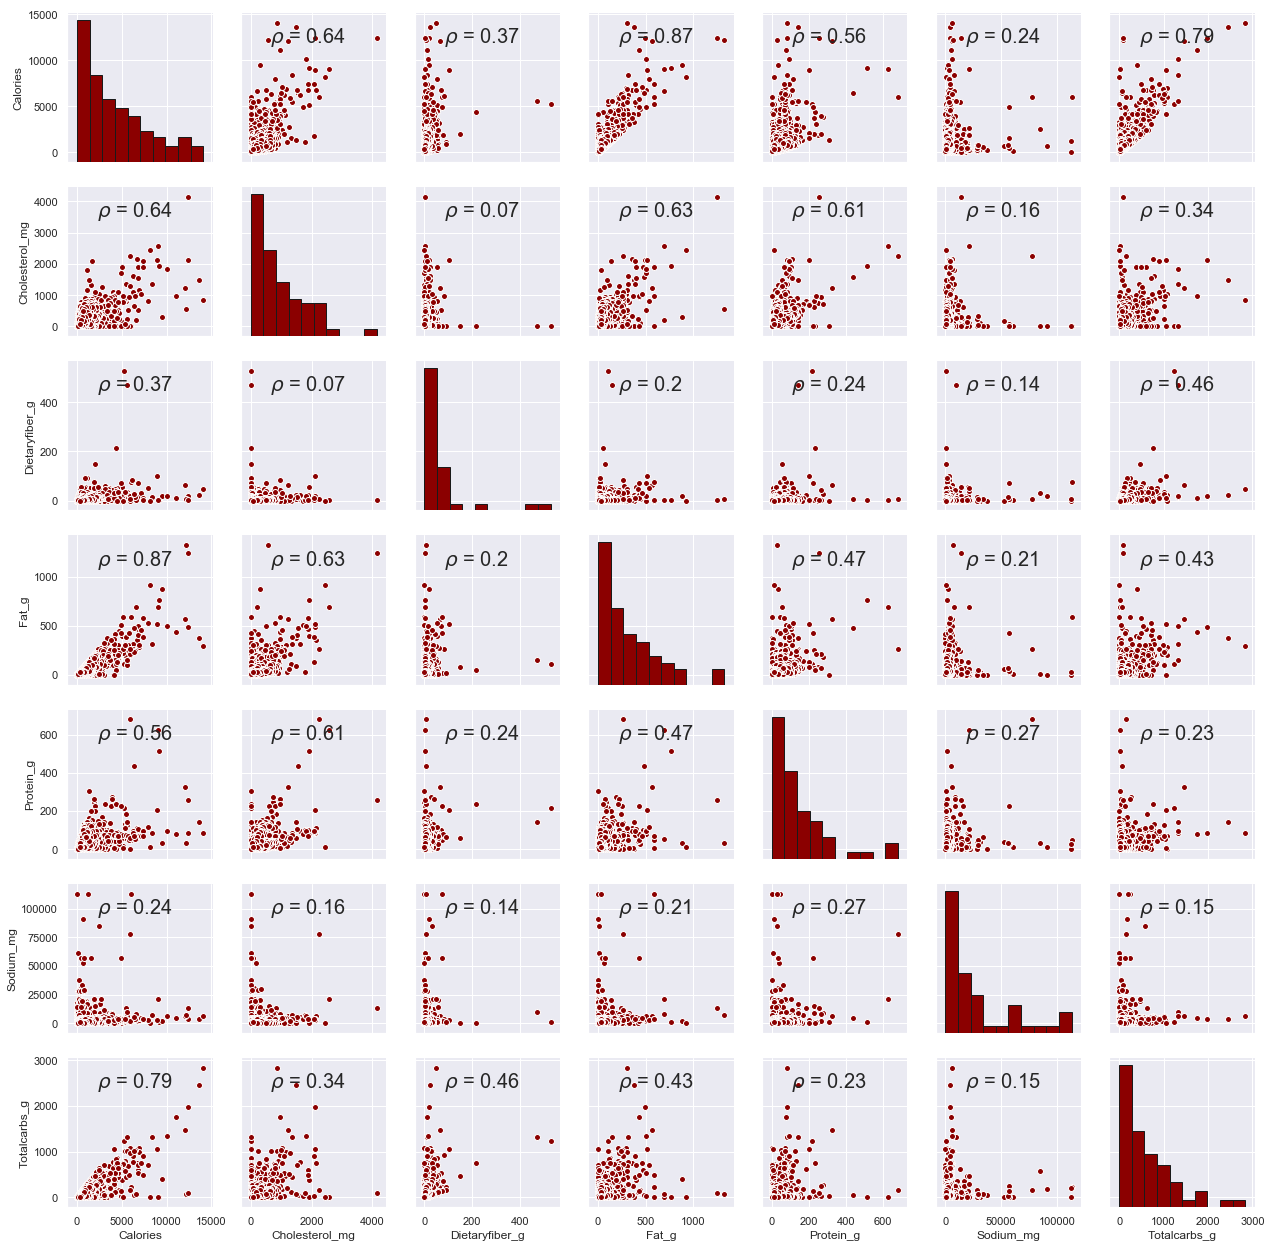

In [56]:
# sns.pairplot(nutrients.dropna())
def corr(x, y, **kwargs):
    # Calculate Pearson Corr
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.8), size = 20, xycoords = ax.transAxes)
# Create a pair grid instance
grid = sns.PairGrid(data= nutrients.dropna())

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, edgecolors='white', color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_diag(plt.hist, log = True, bins = 10, edgecolor = 'k', color = 'darkred')
grid = grid.map_lower(plt.scatter, edgecolors='white', color = 'darkred')
grid = grid.map_lower(corr)

In this part we focused on if a dish is healthy or not by its nutritient information. Below is the recommended daily intake for different nutritients. If a recipe contains higher calories or cholesterol or other nutritients, we classify it as not-calory (or cholesterol, etc.) healthy. And we want to find out the most unhealthy recipe.


Recommended daily intake:

    Calories: 2000 
    Cholesterol: 300mg
    Fiber: 20-40g
    Fat: 40-70g
    Protein: 46-56g
    Sodium: 2300mg
    Carbohydrate: 325g(normal)

In [461]:
Calo = nutrients.loc[nutrients.Calories>=2000].index.get_values()
Chole = nutrients.loc[nutrients.Cholesterol_mg>=300].index.get_values()
Fiber = nutrients.loc[(nutrients.Dietaryfiber_g>40)].index.get_values()
Fat = nutrients.loc[(nutrients.Fat_g>77)].index.get_values()
Protein = nutrients.loc[nutrients.Protein_g>56].index.get_values()
Sodium = nutrients.loc[nutrients.Sodium_mg>2300].index.get_values()
Carb = nutrients.loc[nutrients.Totalcarbs_g>325].index.get_values()

In [462]:
nutri_title = [Calo,Chole,Fiber,Fat,Protein,Sodium,Carb]

In [463]:
flattened_list = [y for x in nutri_title for y in x]

In [464]:
nutri_list = pd.DataFrame(flattened_list)
nutri_list.columns=['Title']
unhealthy = nutri_list.Title.value_counts()

In [465]:
unhealthy.head(10)

Quinoa Banana Bread, Regular or Sugar Free      7
Lemon Kiss Cookies                              7
Baked Mashed Potatoes                           7
Navy Bean Pie (Muslim)                          7
Dawn's Amish Friendship Cake With Starters      7
Wendy's Frosty                                  7
Sweet Potato Mousse With Gooey Praline Sauce    7
Chocolate Fudge Sheet Cake                      6
Baked Shrimp in Italian Dressing                6
Gluten Free Pumpkin Cornbread                   6
Name: Title, dtype: int64

In [406]:
nutrients.loc['Quinoa Banana Bread, Regular or Sugar Free']

Calories          3432.5
Cholesterol_mg     782.0
Dietaryfiber_g      47.6
Fat_g              158.8
Protein_g           72.3
Sodium_mg         2703.1
Totalcarbs_g       464.8
Name: Quinoa Banana Bread, Regular or Sugar Free, dtype: float64

In this way we can see how healthy or unhealthy a recipe is. For example, `Quinoa Banana Bread, Regular or Sugar Free` counts 7 means that it has higher nutritient values in all 7 categories, so it is really unhealthy.

<font color='red'>
    TO BE DONE.
</font>
What we are going to do next, is to combine cuisine type and healthiness of a recipe as well as regional public health information from WHO, and try to figure out the connection of cuisines and risk factors (obesity, noncommunicable disease death rate, high cholesterol and high blood pressure).


## 2.3 Rating & Review

Next we will create a new `Ratings` category containing information about ratings for every recipe available. Since we have ratings information from `allrecipes.com`, `foodnetwork.com` and `yummly.com` we create our dataframe from these dataframes.

In [11]:
ratings = pd.concat([allrecipes.iloc[:,[0,8]].copy(),foodnetwork.iloc[:,[0,5]].copy(),yummly.iloc[:,[9,5]].copy()])
print(ratings.count())
ratings.set_index('Title', inplace=True)
ratings.dropna(how='all', inplace=True)

Title     32576
Rating    20505
dtype: int64


In [392]:
ratings.head(3)

,Rating
Title,
Baked Buffalo Wings,4.4
Fast Rice Pudding,4.1
Chicken Breast Cutlets with Artichokes and Capers,4.4


Here we have 20505 ratings for recipes out of 32576 unique recipes.

Next we will create a new `Reviews` category containing information about number of reviews for every recipe available. We have reviews information from every webpage datafreme available.

In [12]:
reviews = pd.concat([allrecipes.iloc[:,[0,9]].copy(),food.iloc[:,[0,2]].copy(),
                     foodnetwork.iloc[:,[0,6]].copy(),yummly.iloc[:,[9,7]].copy()])
print(reviews.count())
reviews.set_index('Title', inplace=True)
reviews.dropna(how='all', inplace=True)

Title      42286
Reviews    41027
dtype: int64


In [477]:
reviews.head(3)

,Reviews
Title,
Baked Buffalo Wings,519.0
Fast Rice Pudding,75.0
Chicken Breast Cutlets with Artichokes and Capers,80.0


Here we lose a small amount of data and we have 41027 reviews for recipes out of 42286.

/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


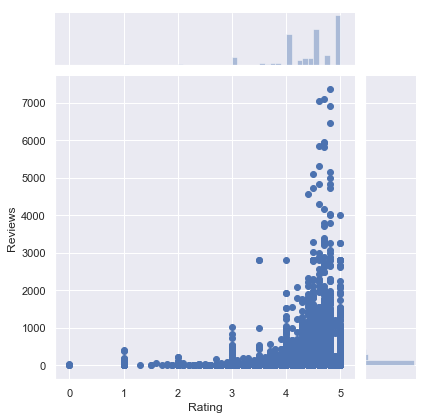

In [18]:
sns.jointplot('Rating', 'Reviews', ratings.join(reviews))
plt.show()

From the plot above we can see that our reviews are denser when we have bigger ratings on recipes and follow a power law.



Next we will create a new `Total cooking time` category containing information about the total time needed to make the recipe for every recipe available. We have total cooking time information from every webpage datafreme available.

In [13]:
total_cook_time = pd.concat([allrecipes.iloc[:,[0,12]].copy(),food.iloc[:,[0,14]].copy(),
                     foodnetwork.iloc[:,[0,2]].copy(),yummly.iloc[:,[9,6]].copy()])
print(total_cook_time.count())
total_cook_time.set_index('Title', inplace=True)
total_cook_time.dropna(how='all', inplace=True)

Title             42286
Total_Time_min    40604
dtype: int64


In [23]:
total_cook_time.sort_values('Total_Time_min',ascending=False).head(20)

,Total_Time_min
Title,
Raspberry Liqueur,172810.0
My Family's Meat Stuffing for a Turkey,86400.0
Cherry Bounce -- A Cordial,86400.0
Dill Pickles by the Jar,60540.0
Apple Brandy,51840.0
English Pub-Style Pickled Onions,50400.0
Dawn's Amish Friendship Cake With Starters,43250.0
Fall Spice Cordial,43210.0
Orange Liqueur,43200.0


Here we lose a small amount of data as before and we have 40604 valid data out of 42286.


We found that the maximum of total time was extremly long. And from above we can notice that the longest cooking time has the recipe for liqueurs, which needs time to ferment.

With rating and review counts, we can answer the first question:
What are the most popular recipes? Do popular cuisines have special preference on nutritients, ingredients or preparation time?

From our dataframes for ratings and reviews we can try to determine which are the most popular recipes. We will sort the recipes by the number of reviews and check the score of the ratings to see if the top recipes have positive or negative reviews (by a threshold), and we select the top negative vs. the top positive popular recipes. 

For example recipe with the most reviews is 'Banana Crumb Muffins' and has an average rating of 4.8 and will belong in the top positive recipes.

In [475]:
reviews.sort_values(by='Reviews', ascending=False).head(1)

,Reviews
Title,
Banana Crumb Muffins,7355.0


In [476]:
ratings[ratings.index == 'Banana Crumb Muffins']

,Rating
Title,
Banana Crumb Muffins,4.8


In [24]:
popular_time_ratings = ratings.sort_values(by='Rating', ascending=False).head(10000).join(total_cook_time).join(reviews).dropna()

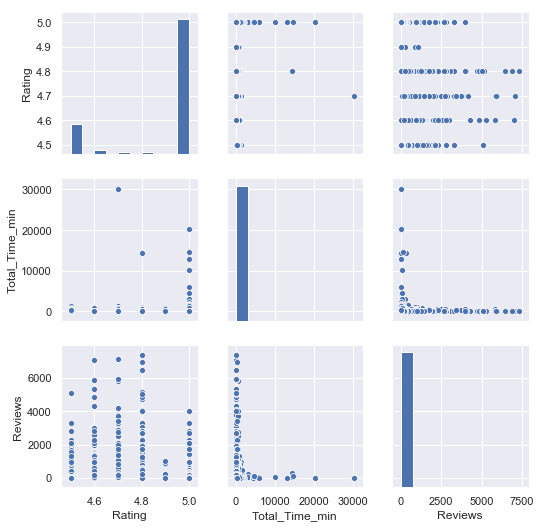

In [25]:
sns.pairplot(popular_time_ratings)

# Part 3 What's next


## 3.1 Ingredient pairs

After having a view of ingredients, we need to think about how to define pairs of ingredients. The ingredient should be the key ingredients in each recipe, for instance in `Chicken Curry Pasta`, ingredient pairs are (chicken, potato), (potato, pasta), (chicken, pasta). Based on this particular stucture which is quite similar to human society, we are going to import `NLTK`, a Natural Language Toolkit or `pyvis.network` to build the network of ingredients. And according to the results, we will analyze the cluster and relation to recipe/region/health. 

## 3.2 Regional Differences

By analyzing the ingredient of regional recipes, we found out that key ingredients vary a lot. For example in Chinese cuisine, the three most common used items are soy sauce, ginger and garlic. In France, however, the top three ingredients are butter, salt and milk. Such big difference in ingredients makes cooking methods various as well as nutrition features. As a result recipes appear in thousands of patterns. With the help of regional difference, we can explore people's eating habits and preferences. Is ingredient-based relationship geographical, climatic or cultural?

## 3.3 Relation to Health

After having a conlusion about regional cuisine difference, we want to know if a relationship exists between recipes and health for a certain region. Threfore, it is necessary to measure how healthy some repcipes are. It should be intuitive and take into account the main aspects of nutrition to discover this. 

We import the Nutri-Score presented by OpenFood. It is a system of notes from A(good) to E(bad) on the front of food products to allow for a simple comparison of the nutritional quality of products. [This website](https://fr.openfoodfacts.org/score-nutritionnel-experimental-france) shows details about formula for calculating the nutritional score, the thresholds of the notes and various adaptation proposals. The advantage is that it's very easy to understand for a customer who has no knowledge in nutrition.